In [61]:
using Pkg

using Flux
using MLDatasets
using Images
using Zygote
using Plots
using Random

Random.seed!(137)
# its not 42, but hopefully its good enough 
;

In [62]:
train_X, train_y = MNIST(split=:train)[:]
test_X, test_y = MNIST(split=:test)[:]

# Normalize the images to the range [0, 1] and convert to Float32
train_X = Float32.(train_X ./ 255.0)
test_X = Float32.(test_X ./ 255.0)

# Reshape the data to match the expected input dimensions (length, channels, batch_size)
train_X = reshape(train_X, size(train_X, 1) * size(train_X, 2), 1, size(train_X, 3))
test_X = reshape(test_X, size(test_X, 1) * size(test_X, 2), 1, size(test_X, 3))

train_X = reshape(train_X, 28, 28, 1, size(train_X, 3))
test_X  = reshape(test_X, 28, 28, 1, size(test_X, 3))

;

In [63]:
encoder_model = Chain(
    Conv((3, 3), 1=>32, relu, pad=1),  # Increased filters
    MaxPool((2,2)),
    Conv((3,3), 32=>64, relu, pad=1),  # Increased filters
    MaxPool((2,2)),
    Flux.flatten,
    Dense(7*7*64, 256, relu),  # Increased neurons
    Dense(256, 7*7*64, relu),  # Increased neurons
    x -> reshape(x, (7, 7, 64, size(x, 2))),
    ConvTranspose((3, 3), 64=>32, relu, stride=2, pad=1),
    ConvTranspose((3, 3), 32=>1, σ, stride=2, pad=1),
    x -> reshape(x, :, size(x, 4)),
    Dense(25*25, 1),
    x -> reshape(x, size(x, 2))
)



Chain(
  Conv((3, 3), 1 => 32, relu, pad=1),   # 320 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, relu, pad=1),  # 18_496 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(3136 => 256, relu),             # 803_072 parameters
  Dense(256 => 3136, relu),             # 805_952 parameters
  var"#63#66"(),
  ConvTranspose((3, 3), 64 => 32, relu, pad=1, stride=2),  # 18_464 parameters
  ConvTranspose((3, 3), 32 => 1, σ, pad=1, stride=2),  # 289 parameters
  var"#64#67"(),
  Dense(625 => 1),                      # 626 parameters
  var"#65#68"(),
)                   # Total: 14 arrays, 1_647_219 parameters, 6.285 MiB.

In [64]:

opt = ADAM();

In [65]:
function train_encoder!(model, train_X, train_Y, opt, epochs, batch_size)
    data_loader = Flux.DataLoader((train_X, train_Y), batchsize=batch_size, shuffle=true)
    
    opt_state = Flux.setup(opt, model)  
    total_loss = []

    for epoch in 1:epochs
        epoch_loss = 0
        for (x, y) in data_loader
            gs = Flux.gradient(model -> Flux.Losses.mse(model(x), y), model)[1]  # Compute gradient for loss
            Flux.update!(opt_state, Flux.trainable(model), gs)  # Update model parameters
            epoch_loss += Flux.Losses.mse(model(x), y)  # Add loss for this batch
        end
        println("Epoch $epoch complete, Loss: $(epoch_loss)")
        push!(total_loss, epoch_loss)  # Track total loss over epochs
    end
    return total_loss
end

train_encoder! (generic function with 1 method)

In [66]:
epochs = 50
batch_size = 64
;

In [67]:
loss_list = train_encoder!(encoder_model, train_X, train_y, opt, epochs, batch_size);

Epoch 1 complete, Loss: 7917.1074
Epoch 2 complete, Loss: 2488.5342
Epoch 3 complete, Loss: 563.57635
Epoch 4 complete, Loss: 366.10782
Epoch 5 complete, Loss: 269.98666
Epoch 6 complete, Loss: 209.04375
Epoch 7 complete, Loss: 169.30313
Epoch 8 complete, Loss: 145.65009
Epoch 9 complete, Loss: 126.21136
Epoch 10 complete, Loss: 106.323074
Epoch 11 complete, Loss: 101.02363
Epoch 12 complete, Loss: 82.71415
Epoch 13 complete, Loss: 77.601
Epoch 14 complete, Loss: 71.68835
Epoch 15 complete, Loss: 59.98373
Epoch 16 complete, Loss: 58.457104
Epoch 17 complete, Loss: 58.335983
Epoch 18 complete, Loss: 50.95986
Epoch 19 complete, Loss: 50.692707
Epoch 20 complete, Loss: 44.215336
Epoch 21 complete, Loss: 41.535313
Epoch 22 complete, Loss: 40.331078
Epoch 23 complete, Loss: 36.608543
Epoch 24 complete, Loss: 36.37378
Epoch 25 complete, Loss: 34.53505
Epoch 26 complete, Loss: 25.994055
Epoch 27 complete, Loss: 29.997131
Epoch 28 complete, Loss: 26.73058
Epoch 29 complete, Loss: 28.266129
Epo

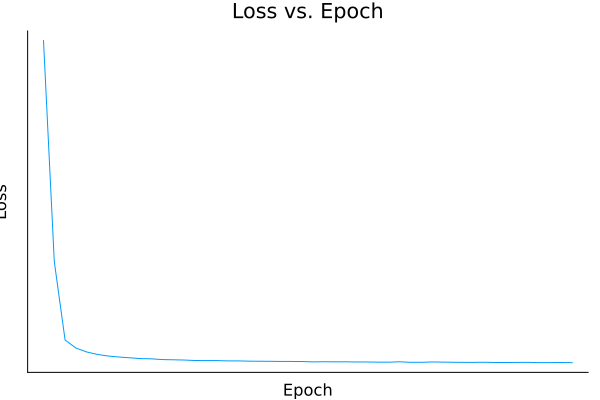

In [68]:
p1 = plot(1:epochs, loss_list, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch", legend=false, xticks=false, yticks=false)
display(p1)

In [69]:
decoder_model = Chain(
    Dense(1, 256, relu),
    Dense(256, 28*28, relu),  # Use 25*25 here instead of 7*7*64 if that makes sense in your model context
    x -> reshape(x, (28, 28, 1, size(x, 2))),
    # Optionally, add additional layers if needed for refinement
    Conv((3, 3), 1=>1, σ, pad=1)  # A final convolution can help refine the output
)

Chain(
  Dense(1 => 256, relu),                # 512 parameters
  Dense(256 => 784, relu),              # 201_488 parameters
  var"#71#72"(),
  Conv((3, 3), 1 => 1, σ, pad=1),       # 10 parameters
)                   # Total: 6 arrays, 202_010 parameters, 789.492 KiB.

In [70]:
autoencoder_model = Chain(encoder_model, decoder_model);

In [71]:
# Training loop for decoder

opt_state_auto = Flux.setup(opt, autoencoder_model)  

for epoch in 1:epochs

    data_loader = Flux.DataLoader((train_X, train_y), batchsize=1, shuffle=true)

    for (x, y) in data_loader

        X_batch = x  # Original image batch
        Y_batch = X_batch   # For autoencoders, target is the input image

        # Forward pass
        reconstructed = autoencoder_model(X_batch)


        gs = Flux.gradient(model -> Flux.Losses.logitbinarycrossentropy(X_batch, reconstructed), autoencoder_model)[1]  
        Flux.update!(opt_state_auto, Flux.trainable(autoencoder_model), gs)
    end

    println("Epoch $epoch complete")

end


Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete
Epoch 10 complete
Epoch 11 complete
Epoch 12 complete
Epoch 13 complete
Epoch 14 complete
Epoch 15 complete
Epoch 16 complete
Epoch 17 complete
Epoch 18 complete
Epoch 19 complete
Epoch 20 complete
Epoch 21 complete
Epoch 22 complete
Epoch 23 complete
Epoch 24 complete
Epoch 25 complete
Epoch 26 complete
Epoch 27 complete
Epoch 28 complete
Epoch 29 complete
Epoch 30 complete
Epoch 31 complete
Epoch 32 complete
Epoch 33 complete
Epoch 34 complete
Epoch 35 complete
Epoch 36 complete
Epoch 37 complete
Epoch 38 complete
Epoch 39 complete
Epoch 40 complete
Epoch 41 complete
Epoch 42 complete
Epoch 43 complete
Epoch 44 complete
Epoch 45 complete
Epoch 46 complete
Epoch 47 complete
Epoch 48 complete
Epoch 49 complete
Epoch 50 complete


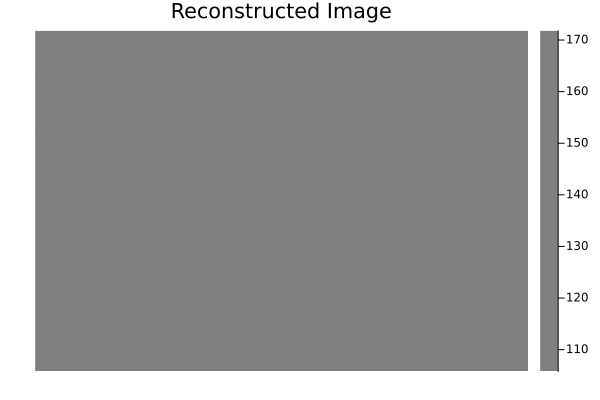

In [72]:
sample_input = rand(Float32, 28, 28, 1, 1)  # Single 28x28 image with 1 channel

# Forward pass through the model to get the reconstructed image
reconstructed_image = autoencoder_model(sample_input)

# Reshape the output (if necessary, e.g., to 28x28 format)
reconstructed_image = reshape(reconstructed_image, 28, 28) .* 255.0

# Display the image
heatmap(reconstructed_image, color=:gray, axis=false, title="Reconstructed Image")